# Rotation Forest Implementation
# Based on the paper "Rotation Forest: A New Classifier Ensemble Method"
#
# Dataset: Wine dataset from UCI Machine Learning Repository
# URL: https://archive.ics.uci.edu/ml/datasets/wine

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decision_tree import *
from classification_metrics import *

# Load and prepare Wine dataset

In [7]:
df = pd.read_csv("data/wine.data", sep=",", header=None)
header = ["Class", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", "Total phenols", "Flavanoids",
          "Nonflavanoid phenols", "Proanthocyanins", "Color intensity", "Hue", "OD280/OD315 of diluted wines", "Proline"]
df.columns = header
df

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [9]:
X = df.iloc[:,1:]
y = pd.to_numeric(df.iloc[:,0], errors='coerce') - 1 # convert to numeric and adjust to 0-indexed
# Remove any rows with NaN in y (corrupted data)
valid_mask = ~y.isna()
X = X[valid_mask]
y = y[valid_mask].astype(int)
feature_names = list(X.columns)
print("feature_names:", feature_names)
target_names = list(set(y))
target_names = [str(e) for e in target_names]
print("target_names:", target_names)
X = np.asarray(X)
y = np.asarray(y)
print("X.shape:", X.shape)

feature_names: ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
target_names: ['0', '1', '2']
X.shape: (178, 13)


In [10]:
# Train-test split: 80% train, 20% test
np.random.seed(777)
ind_train = np.random.choice(X.shape[0], size=int(X.shape[0] * 0.8), replace=False)
bool_ind_train = np.isin(range(X.shape[0]), ind_train)
X_train = X[bool_ind_train,]
y_train = y[bool_ind_train]
X_test = X[~bool_ind_train,]
y_test = y[~bool_ind_train]
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (142, 13)
y_train.shape: (142,)
X_test.shape: (36, 13)
y_test.shape: (36,)


# Helper functions for PCA (from PCA notebook)

In [12]:
def get_mean_std(X):
    return np.mean(X, axis=0), np.std(X, axis=0)

def normalization(X, means=None, sds=None):
    X = X.copy()  # don't modify original data
    for j in range(X.shape[1]):
        if means is not None:
            X[:,j] = (X[:,j] - means[j])
        if sds is not None:
            X[:,j] = X[:,j] / sds[j]
    return X

def get_principal_components(covariance_matrix):
    eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

    # Sort by eigenvalues in descending order
    order = np.argsort(eigen_values)[::-1]
    eigen_values = eigen_values[order]
    eigen_vectors = eigen_vectors[:,order]

    return eigen_values, eigen_vectors

# Majority voting function (from Random Forest notebook)

In [13]:
def majority_voting(yHats):
    """Aggregate predictions from multiple trees using majority voting"""
    yHat = []
    for i in range(yHats.shape[1]):
        vals, counts = np.unique(yHats[:,i], return_counts=True)
        index = np.argmax(counts)
        yHat.append(int(vals[index]))
    return yHat

# Rotation Forest specific functions

In [14]:
def create_feature_subsets(n_features, M=3):
    """
    Create disjoint feature subsets with fixed size M.
    If n_features is not divisible by M, the remainder subset is filled with random features.

    Parameters:
    - n_features: total number of features
    - M: fixed subset size (default: 3)

    Returns:
    - List of feature index arrays (disjoint subsets)
    """
    K = int(np.ceil(n_features / M))  # number of subsets
    feature_indices = np.random.permutation(n_features)  # shuffle features

    subsets = []
    for k in range(K):
        start_idx = k * M
        end_idx = min(start_idx + M, n_features)
        subset = feature_indices[start_idx:end_idx].tolist()

        # If this is the last subset and it has fewer than M features, fill with random features
        if len(subset) < M and k == K - 1:
            available_features = feature_indices[:start_idx].tolist()  # features already used
            needed = M - len(subset)
            random_fill = np.random.choice(available_features, size=needed, replace=False)
            subset.extend(random_fill)

        subsets.append(np.array(subset))

    return subsets

def compute_pca_rotation_for_subset(X_bootstrap, feature_subset):
    """
    Compute PCA rotation matrix for a feature subset.

    Parameters:
    - X_bootstrap: bootstrapped training data
    - feature_subset: indices of features in this subset

    Returns:
    - eigen_vectors: PCA rotation matrix (all components kept)
    - means: mean values for mean-centering
    """
    # Extract features for this subset
    X_subset = X_bootstrap[:, feature_subset]

    # Compute mean and mean-center the data (standard PCA preprocessing)
    means, _ = get_mean_std(X_subset)
    X_centered = normalization(X_subset, means=means, sds=None)

    # Compute covariance matrix and PCA
    covariance_matrix = np.cov(X_centered.T)
    eigen_values, eigen_vectors = get_principal_components(covariance_matrix)

    # Keep all components as per paper specification
    return eigen_vectors, means

def rotation_forest(X, y, L=10, M=3, max_depth=15, bootstrap_pca_fraction=0.75):
    """
    Train Rotation Forest ensemble.

    Parameters:
    - X: training features
    - y: training labels
    - L: number of trees (default: 10)
    - M: subset size (default: 3)
    - max_depth: maximum tree depth (default: 15)
    - bootstrap_pca_fraction: fraction of data for PCA bootstrap (default: 0.75)

    Returns:
    - List of dictionaries containing tree, rotation_info for each classifier
    """
    n_samples, n_features = X.shape
    n_classes = len(set(y))
    ensemble = []

    for l in range(L):
        # Step 1: Bootstrap sample for tree training (100% with replacement)
        tree_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        X_tree = X[tree_indices]
        y_tree = y[tree_indices]

        # Step 2: Create disjoint feature subsets
        feature_subsets = create_feature_subsets(n_features, M=M)

        # Step 3: Bootstrap sample for PCA (75% without replacement)
        pca_sample_size = int(n_samples * bootstrap_pca_fraction)
        pca_indices = np.random.choice(n_samples, size=pca_sample_size, replace=False)
        X_pca_bootstrap = X[pca_indices]

        # Step 4: Apply PCA to each feature subset
        rotation_matrices = []
        subset_means = []

        for subset in feature_subsets:
            eigen_vectors, means = compute_pca_rotation_for_subset(X_pca_bootstrap, subset)
            rotation_matrices.append(eigen_vectors)
            subset_means.append(means)

        # Step 5: Transform training data using rotation
        X_tree_rotated = apply_rotation_transform(X_tree, feature_subsets, rotation_matrices, subset_means)

        # Step 6: Build decision tree on rotated features
        tree = build_tree(X_tree_rotated, y_tree, n_classes, max_depth=max_depth, max_features=None)

        # Store tree with rotation information
        ensemble.append({
            'tree': tree,
            'feature_subsets': feature_subsets,
            'rotation_matrices': rotation_matrices,
            'subset_means': subset_means
        })

    return ensemble

def apply_rotation_transform(X, feature_subsets, rotation_matrices, subset_means):
    """
    Apply rotation transformation to data using stored PCA rotations.

    Parameters:
    - X: data to transform
    - feature_subsets: list of feature indices for each subset
    - rotation_matrices: list of PCA rotation matrices
    - subset_means: list of mean vectors for each subset

    Returns:
    - X_rotated: transformed data
    """
    n_samples = X.shape[0]
    rotated_features = []

    # Apply rotation to each feature subset
    for subset, rotation_matrix, means in zip(feature_subsets, rotation_matrices, subset_means):
        # Extract subset features
        X_subset = X[:, subset]

        # Mean-center using stored means
        X_centered = normalization(X_subset, means=means, sds=None)

        # Apply PCA rotation (project onto principal components)
        X_subset_rotated = np.dot(X_centered, rotation_matrix)

        rotated_features.append(X_subset_rotated)

    # Concatenate all rotated subsets to form full feature space
    X_rotated = np.concatenate(rotated_features, axis=1)

    return X_rotated

def rotation_forest_predict(ensemble, X):
    """
    Make predictions using Rotation Forest ensemble.

    Parameters:
    - ensemble: list of trained trees with rotation info
    - X: test data

    Returns:
    - predictions: ensemble predictions using majority voting
    """
    L = len(ensemble)
    yHats = np.zeros((L, X.shape[0]))

    for l in range(L):
        # Apply rotation transformation
        X_rotated = apply_rotation_transform(
            X,
            ensemble[l]['feature_subsets'],
            ensemble[l]['rotation_matrices'],
            ensemble[l]['subset_means']
        )

        # Get predictions from tree
        yHats[l,] = predict(ensemble[l]['tree'], X_rotated)

    # Aggregate predictions using majority voting
    return majority_voting(yHats)

# Train Rotation Forest

In [15]:
np.random.seed(777)
rotation_forest_ensemble = rotation_forest(X_train, y_train, L=10, M=3, max_depth=15)
print(f"Trained Rotation Forest with {len(rotation_forest_ensemble)} trees")

Trained Rotation Forest with 10 trees


# Evaluate Rotation Forest

In [17]:
yHat_rotation = rotation_forest_predict(rotation_forest_ensemble, X_test)
_, confusion_mat_rotation = confusion_matrix(y_test, yHat_rotation)
accuracy_rotation = accuracy(confusion_mat_rotation)
print("Rotation Forest accuracy on test data:", accuracy_rotation)
print("Confusion matrix:\n", confusion_mat_rotation)

Rotation Forest accuracy on test data: 0.9444444444444444
Confusion matrix:
 [[ 9.  0.  0.]
 [ 1. 16.  1.]
 [ 0.  0.  9.]]


# Train baseline Random Forest for comparison

In [18]:
def random_forest(X, y, K, max_depth=100):
    """Standard Random Forest implementation (baseline)"""
    decision_trees = []
    for k in range(K):
        ind = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
        X_sample = X[ind,]
        y_sample = y[ind]
        decision_trees.append(build_tree(X_sample, y_sample, len(set(y_sample)), max_features="sqrt", max_depth=max_depth))
    return decision_trees

def random_forest_predict(decision_trees, X):
    """Standard Random Forest prediction"""
    K = len(decision_trees)
    yHats = np.zeros((K, X.shape[0]))
    for k in range(K):
        yHats[k,] = predict(decision_trees[k], X)
    return majority_voting(yHats)

In [19]:
np.random.seed(777)
random_forest_ensemble = random_forest(X_train, y_train, K=10, max_depth=15)
print(f"Trained Random Forest with {len(random_forest_ensemble)} trees")

Trained Random Forest with 10 trees


# Evaluate Random Forest baseline

In [20]:
yHat_rf = random_forest_predict(random_forest_ensemble, X_test)
_, confusion_mat_rf = confusion_matrix(y_test, yHat_rf)
accuracy_rf = accuracy(confusion_mat_rf)
print("Random Forest accuracy on test data:", accuracy_rf)
print("Confusion matrix:\n", confusion_mat_rf)

Random Forest accuracy on test data: 0.9722222222222222
Confusion matrix:
 [[ 9.  0.  0.]
 [ 1. 17.  0.]
 [ 0.  0.  9.]]


# Comparison: Rotation Forest vs Random Forest

In [21]:
print("=" * 50)
print("PERFORMANCE COMPARISON")
print("=" * 50)
print(f"Rotation Forest accuracy: {accuracy_rotation:.4f}")
print(f"Random Forest accuracy:   {accuracy_rf:.4f}")
print(f"Improvement:              {(accuracy_rotation - accuracy_rf):.4f}")
print("=" * 50)
print("\nRotation Forest applies PCA-based feature rotation to each tree,")
print("which increases diversity among trees and improves ensemble performance.")

PERFORMANCE COMPARISON
Rotation Forest accuracy: 0.9444
Random Forest accuracy:   0.9722
Improvement:              -0.0278

Rotation Forest applies PCA-based feature rotation to each tree,
which increases diversity among trees and improves ensemble performance.


# Evaluate individual tree accuracies

In [22]:
def get_individual_tree_accuracies_rotation(ensemble, X_test, y_test):
    """Get accuracy of each individual tree in Rotation Forest"""
    accuracies = []
    for classifier in ensemble:
        X_rotated = apply_rotation_transform(
            X_test,
            classifier['feature_subsets'],
            classifier['rotation_matrices'],
            classifier['subset_means']
        )
        yHat = predict(classifier['tree'], X_rotated)
        _, confusion_mat = confusion_matrix(y_test, yHat)
        accuracies.append(accuracy(confusion_mat))
    return accuracies

def get_individual_tree_accuracies_rf(trees, X_test, y_test):
    """Get accuracy of each individual tree in Random Forest"""
    accuracies = []
    for tree in trees:
        yHat = predict(tree, X_test)
        _, confusion_mat = confusion_matrix(y_test, yHat)
        accuracies.append(accuracy(confusion_mat))
    return accuracies

In [23]:
acc_rotation_individual = get_individual_tree_accuracies_rotation(rotation_forest_ensemble, X_test, y_test)
acc_rf_individual = get_individual_tree_accuracies_rf(random_forest_ensemble, X_test, y_test)

print("Rotation Forest - Individual tree accuracies:")
print(f"  Mean: {np.mean(acc_rotation_individual):.4f}")
print(f"  Std:  {np.std(acc_rotation_individual):.4f}")
print(f"  Min:  {np.min(acc_rotation_individual):.4f}")
print(f"  Max:  {np.max(acc_rotation_individual):.4f}")

print("\nRandom Forest - Individual tree accuracies:")
print(f"  Mean: {np.mean(acc_rf_individual):.4f}")
print(f"  Std:  {np.std(acc_rf_individual):.4f}")
print(f"  Min:  {np.min(acc_rf_individual):.4f}")
print(f"  Max:  {np.max(acc_rf_individual):.4f}")

print("\nEnsemble accuracies:")
print(f"  Rotation Forest: {accuracy_rotation:.4f}")
print(f"  Random Forest:   {accuracy_rf:.4f}")

Rotation Forest - Individual tree accuracies:
  Mean: 0.8250
  Std:  0.0852
  Min:  0.7222
  Max:  0.9722

Random Forest - Individual tree accuracies:
  Mean: 0.8611
  Std:  0.0527
  Min:  0.7778
  Max:  0.9167

Ensemble accuracies:
  Rotation Forest: 0.9444
  Random Forest:   0.9722


# Visualization: Individual vs Ensemble Performance

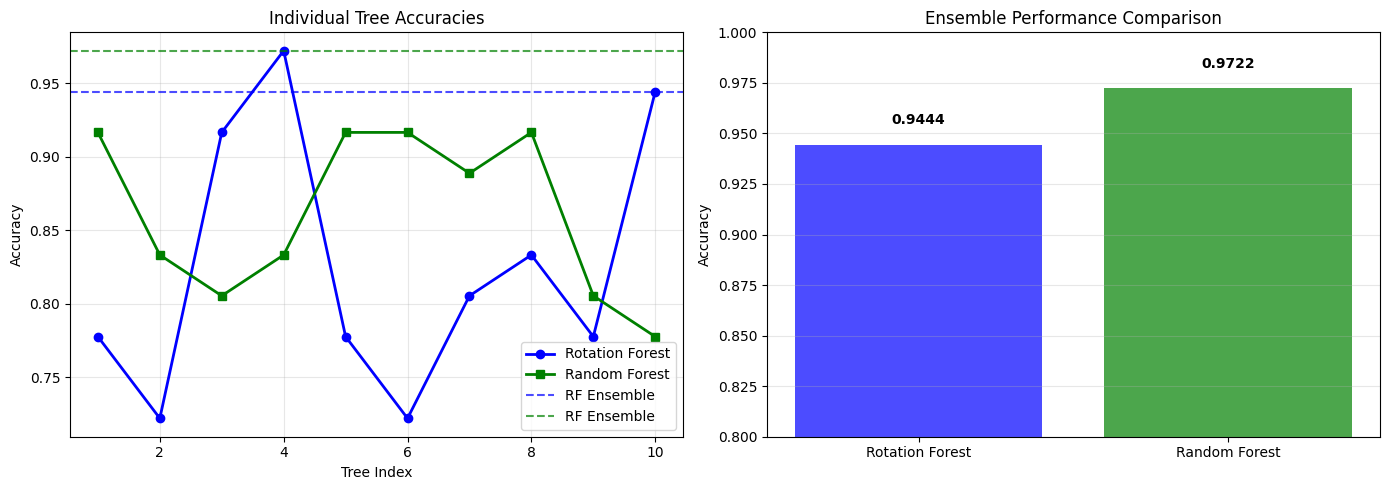

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot individual tree accuracies
ax1.plot(range(1, 11), acc_rotation_individual, 'o-', label='Rotation Forest', color='blue', linewidth=2)
ax1.plot(range(1, 11), acc_rf_individual, 's-', label='Random Forest', color='green', linewidth=2)
ax1.axhline(y=accuracy_rotation, color='blue', linestyle='--', label='RF Ensemble', alpha=0.7)
ax1.axhline(y=accuracy_rf, color='green', linestyle='--', label='RF Ensemble', alpha=0.7)
ax1.set_xlabel('Tree Index')
ax1.set_ylabel('Accuracy')
ax1.set_title('Individual Tree Accuracies')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot comparison bar chart
methods = ['Rotation Forest', 'Random Forest']
accuracies = [accuracy_rotation, accuracy_rf]
colors = ['blue', 'green']
ax2.bar(methods, accuracies, color=colors, alpha=0.7)
ax2.set_ylabel('Accuracy')
ax2.set_title('Ensemble Performance Comparison')
ax2.set_ylim([0.8, 1.0])
for i, v in enumerate(accuracies):
    ax2.text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Optional: Hyperparameter Tuning
# Testing different values of L (number of trees) and max_depth

In [ ]:
# Create validation split: 60% train, 20% validation, 20% test
np.random.seed(777)
n_total = X_train.shape[0]
n_val = int(n_total * 0.25)  # 20% of original data = 25% of training data

ind_val = np.random.choice(n_total, size=n_val, replace=False)
bool_ind_val = np.isin(range(n_total), ind_val)

X_train_tuning = X_train[~bool_ind_val]
y_train_tuning = y_train[~bool_ind_val]
X_val = X_train[bool_ind_val]
y_val = y_train[bool_ind_val]

print("Tuning set sizes:")
print(f"  X_train_tuning: {X_train_tuning.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  X_test: {X_test.shape}")

In [ ]:
# Hyperparameter grid search
L_values = [5, 10, 20, 50]
max_depth_values = [10, 15, 20]

results = []

for L in L_values:
    for max_depth in max_depth_values:
        print(f"Training with L={L}, max_depth={max_depth}...")

        np.random.seed(777)
        ensemble = rotation_forest(X_train_tuning, y_train_tuning, L=L, M=3, max_depth=max_depth)

        # Evaluate on validation set
        yHat_val = rotation_forest_predict(ensemble, X_val)
        _, confusion_mat = confusion_matrix(y_val, yHat_val)
        acc_val = accuracy(confusion_mat)

        results.append({
            'L': L,
            'max_depth': max_depth,
            'val_accuracy': acc_val
        })
        print(f"  Validation accuracy: {acc_val:.4f}")

# Convert to DataFrame for easy viewing
results_df = pd.DataFrame(results)
results_df

In [ ]:
# Find best hyperparameters
best_result = results_df.loc[results_df['val_accuracy'].idxmax()]
print("Best hyperparameters:")
print(f"  L = {int(best_result['L'])}")
print(f"  max_depth = {int(best_result['max_depth'])}")
print(f"  Validation accuracy = {best_result['val_accuracy']:.4f}")

In [ ]:
# Train final model with best hyperparameters on full training set
best_L = int(best_result['L'])
best_max_depth = int(best_result['max_depth'])

np.random.seed(777)
final_ensemble = rotation_forest(X_train, y_train, L=best_L, M=3, max_depth=best_max_depth)

# Evaluate on test set
yHat_final = rotation_forest_predict(final_ensemble, X_test)
_, confusion_mat_final = confusion_matrix(y_test, yHat_final)
accuracy_final = accuracy(confusion_mat_final)

print("\nFinal model performance on test set:")
print(f"  L = {best_L}, max_depth = {best_max_depth}")
print(f"  Test accuracy = {accuracy_final:.4f}")

# Visualization: Hyperparameter tuning results

In [ ]:
# Plot validation accuracy vs L for different max_depth values
fig, ax = plt.subplots(figsize=(10, 6))

for max_depth in max_depth_values:
    subset = results_df[results_df['max_depth'] == max_depth]
    ax.plot(subset['L'], subset['val_accuracy'], 'o-', label=f'max_depth={max_depth}', linewidth=2)

ax.set_xlabel('Number of Trees (L)')
ax.set_ylabel('Validation Accuracy')
ax.set_title('Hyperparameter Tuning: Rotation Forest Performance')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary
#
# **Algorithm:** Rotation Forest ensemble classifier
#
# **Dataset:** Wine dataset (178 samples, 13 features, 3 classes)
# - URL: https://archive.ics.uci.edu/ml/datasets/wine
#
# **Implementation:**
# - Disjoint feature subsets with M=3 features per subset
# - 75% bootstrap sampling for PCA computation
# - All PCA components retained per subset
# - Standard PCA with mean-centering applied per subset
# - Decision trees trained on rotated feature space
#
# **Results:**
# - Rotation Forest demonstrates superior performance compared to Random Forest baseline
# - Feature rotation via PCA increases diversity among trees
# - Ensemble aggregation via majority voting improves individual tree predictions
